## Calculate Error Doubling Times

In [2]:
from dask.distributed import Client
client = Client(n_workers=16,threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37983,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:35793,Total threads: 1
Dashboard: http://127.0.0.1:34889/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:44703,


In [3]:
from glob import glob 
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs 
import os 
import re 

def load_am4(month='jan'):
    BASE_DIR = os.path.join('/scratch/users/robcking/am4_error_growth_full',month)

    #LOAD PERTURBED ENSEMBLES
    perturbed_memberlist = sorted(filter(lambda x: re.match(r'.+\/[0-9]+\/atmos_4xdaily.nc',x),glob(os.path.join(BASE_DIR,'*','atmos_4xdaily.nc'))),key=lambda x: int(re.search(r'\w+\/(\d+)\/\w+.nc',x).group(1)))
    perturbed_ds =  xr.open_mfdataset(perturbed_memberlist,combine='nested',concat_dim='members',chunks={'pfull':11,'lat':50})

    #LOAD CTL PATH
    ctl_path = os.path.join(BASE_DIR,'ctl','atmos_4xdaily.nc')
    ctl_ds = xr.open_dataset(ctl_path,chunks={'pfull':11,'lat':50})

    return perturbed_ds,ctl_ds

def load_mima(month='jan'):
    BASE_DIR = os.path.join('/scratch/users/robcking/mima_predictability',month)
    perturbed_memberlist = sorted(filter(lambda x: re.match(r'.+\/[0-9]+\/atmos_4xdaily.nc',x),glob(os.path.join(BASE_DIR,'*','atmos_4xdaily.nc'))),key=lambda x: int(re.search(r'\w+\/(\d+)\/\w+.nc',x).group(1)))
    perturbed_ds =  xr.open_mfdataset(perturbed_memberlist,combine='nested',concat_dim='members',chunks={'pfull':11,'lat':40},decode_times=False)

    #LOAD CTL PATH
    ctl_path = os.path.join(BASE_DIR,'ctl','atmos_4xdaily.nc')
    ctl_ds = xr.open_dataset(ctl_path,chunks={'pfull':11,'lat':50},decode_times=False)
    return perturbed_ds,ctl_ds

def load_icon():
    BASE_ICON = '/scratch/groups/aditis2/icon_coarse'

    perturbed_memberlist = sorted(glob(os.path.join(BASE_ICON,'**','icon_p[0-9].nc')),key=lambda x: int(re.search(r'[\w\/]*icon_p([0-9]+).nc',x).group(1))) # This **should** auto sort? 
    perturbed_ds = xr.open_mfdataset(perturbed_memberlist,combine='nested',concat_dim='members',chunks='auto')
    #LOAD CTL PATH
    ctl_path = os.path.join(BASE_ICON,'base/icon_base.nc')
    ctl_ds = xr.open_dataset(ctl_path,chunks='auto')
    ctl_ds = ctl_ds.chunk({'time':-1,'lat':64})
    perturbed_ds = perturbed_ds.chunk({'time':-1,'lat':64})
    return perturbed_ds, ctl_ds

In [4]:
def calculate_mse(perturbed_var,ctl_var):
    return ((perturbed_var - ctl_var)**2.0).mean(dim='members')


In [5]:
am4_jan_ens,am4_jan_ctl = load_am4(month='jan')
am4_jan_ctl

<xarray.Dataset> Size: 13GB
Dimensions:       (time: 360, lon: 360, bnds: 2, lat: 180, pfull: 33)
Coordinates:
  * time          (time) datetime64[ns] 3kB 1979-01-01T06:00:00 ... 1979-04-01
  * lon           (lon) float64 3kB 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * lat           (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * pfull         (pfull) float64 264B 2.164 5.845 10.75 ... 985.4 992.8 997.9
Dimensions without coordinates: bnds
Data variables: (12/16)
    grid_xt_bnds  (lon, bnds) float64 6kB dask.array<chunksize=(360, 2), meta=np.ndarray>
    grid_yt_bnds  (lat, bnds) float64 3kB dask.array<chunksize=(50, 2), meta=np.ndarray>
    ucomp         (time, pfull, lat, lon) float32 3GB dask.array<chunksize=(360, 11, 50, 360), meta=np.ndarray>
    u_ref         (time, lat, lon) float32 93MB dask.array<chunksize=(360, 50, 360), meta=np.ndarray>
    vcomp         (time, pfull, lat, lon) float32 3GB dask.array<chunksize=(360, 11, 50, 360), meta=np.ndarray>
    v_ref         (time, lat, lon) float32 93MB dask.array<chunksize=(360, 50, 360), meta=np.ndarray>
    ...            ...
    slp           (time, lat, lon) float32 93MB dask.array<chunksize=(360, 50, 360), meta=np.ndarray>
    tm            (time, lat, lon) float32 93MB dask.array<chunksize=(360, 50, 360), meta=np.ndarray>
    olr           (time, lat, lon) float32 93MB dask.array<chunksize=(360, 50, 360), meta=np.ndarray>
    precip        (time, lat, lon) float32 93MB dask.array<chunksize=(360, 50, 360), meta=np.ndarray>
    prec_ls       (time, lat, lon) float32 93MB dask.array<chunksize=(360, 50, 360), meta=np.ndarray>
    average_DT    (time) timedelta64[ns] 3kB dask.array<chunksize=(360,), meta=np.ndarray>
Attributes:
    CDI:                   Climate Data Interface version 2.1.1 (https://mpim...
    Conventions:           CF-1.6
    title:                 c96L33_am4p0
    grid_type:             regular
    grid_tile:             N/A
    code_release_version:  2023.01.02
    git_hash:              8176c2b45079431f2053ec773253938f8aee4828
    creationtime:          Tue Oct 22 14:21:21 2024
    hostname:              sh03-09n29.int
    history:               Tue Oct 22 15:38:19 2024: ncrename -v grid_xt,lon ...
    CDO:                   Climate Data Operators version 2.1.1 (https://mpim...
    NCO:                   netCDF Operators version 4.8.0 (Homepage = http://...

In [6]:
from scipy.optimize import curve_fit
import warnings

def piecewise_sat(t,t_tr,error_doubling,log2_sat_e):
    err = np.piecewise(t,[t < t_tr,t>=t_tr],[lambda t:(1/error_doubling)*(t-t_tr) + log2_sat_e,log2_sat_e])
    return err 

def fit_piecewise(t,log2_err_vals):
    if np.isinf(log2_err_vals).any():
        return np.array([np.nan,np.nan,np.nan])
    tmax = np.max(t)
    try:
        popt,pcov = curve_fit(piecewise_sat,t,log2_err_vals,bounds=(0,[tmax,tmax*10,np.inf]))
    except RuntimeError:
        warnings.warn("Fit not obtained, using fall back params")
        popt = np.array([np.nan,np.nan,np.nan])
    return np.array(popt)

def plot_intersection(ds):
    fig,ax = plt.subplots()
    time = np.arange(0.25, (len(ds.time)+1)*0.25,0.25)
    err_vals = ds.values
    ax.plot(time,err_vals)
    ax.set_yscale('log',base=2)
    popt =fit_piecewise(time,ds.values)
    ax.plot(time,2.0**(piecewise_sat(time,*popt)))


AM4 Jan

In [11]:
from functools import partial
for var in ['precip','hght']:
    print(f"Working on :{var}")
    mse = calculate_mse(am4_jan_ens[var],am4_jan_ctl[var])
    time = np.arange(0.25, (len(mse.time)+1)*0.25,0.25)
    fit_piecewise_t = partial(fit_piecewise,time)
    mse_log2 = np.log2(mse)
    mse_fit_params = xr.apply_ufunc(fit_piecewise_t,mse_log2,input_core_dims=[['time']],output_core_dims=[['params']],dask='parallelized',vectorize=True,dask_gufunc_kwargs={'output_sizes':{'params':3}})
    mse_fit_params.to_netcdf(f'/scratch/users/robcking/am4_jan_piecewise_params_{var}.nc')

Working on :precip


/home/users/robcking/experiments/error_sat/env/lib/python3.12/site-packages/dask/core.py:133: RuntimeWarning: divide by zero encountered in log2
  return func(*(_execute_task(a, cache) for a in args))
/home/users/robcking/experiments/error_sat/env/lib/python3.12/site-packages/dask/core.py:133: RuntimeWarning: divide by zero encountered in log2
  return func(*(_execute_task(a, cache) for a in args))
/home/users/robcking/experiments/error_sat/env/lib/python3.12/site-packages/dask/core.py:133: RuntimeWarning: divide by zero encountered in log2
  return func(*(_execute_task(a, cache) for a in args))


Working on :hght


In [12]:
am4_jan_ens.close()
am4_jan_ctl.close()


AM4 JUL

In [13]:
am4_jul_ens,am4_jul_ctl = load_am4(month='jul')
for var in ['ucomp','vcomp','temp','u_ref','v_ref','t_ref','olr','precip','hght']:
    print(f"Working on :{var}")
    mse = calculate_mse(am4_jul_ens[var],am4_jul_ctl[var])
    time = np.arange(0.25, (len(mse.time)+1)*0.25,0.25)
    fit_piecewise_t = partial(fit_piecewise,time)
    mse_log2 = np.log2(mse)
    mse_fit_params = xr.apply_ufunc(fit_piecewise_t,mse_log2,input_core_dims=[['time']],output_core_dims=[['params']],dask='parallelized',vectorize=True,dask_gufunc_kwargs={'output_sizes':{'params':3}})
    mse_fit_params.to_netcdf(f'/scratch/users/robcking/am4_jul_piecewise_params_{var}.nc')

Working on :ucomp
Working on :vcomp


MiMA

In [8]:
mima_jan_ctl

<xarray.Dataset> Size: 1GB
Dimensions:  (lon: 128, lonb: 129, lat: 64, latb: 65, pfull: 40, phalf: 41,
              time: 360)
Coordinates:
  * lon      (lon) float32 512B 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
  * lonb     (lonb) float32 516B -1.406 1.406 4.219 7.031 ... 353.0 355.8 358.6
  * lat      (lat) float32 256B -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * latb     (latb) float32 260B -90.0 -86.58 -83.76 -80.96 ... 83.76 86.58 90.0
  * pfull    (pfull) float32 160B 0.1782 0.5562 0.7238 ... 821.4 902.2 970.5
  * phalf    (phalf) float32 164B 0.0 0.4844 0.6312 0.8205 ... 863.5 941.4 1e+03
  * time     (time) float64 3kB 1.8e+03 1.8e+03 1.801e+03 ... 1.89e+03 1.89e+03
Data variables:
    ucomp    (time, pfull, lat, lon) float32 472MB dask.array<chunksize=(360, 11, 50, 128), meta=np.ndarray>
    vcomp    (time, pfull, lat, lon) float32 472MB dask.array<chunksize=(360, 11, 50, 128), meta=np.ndarray>
    temp     (time, pfull, lat, lon) float32 472MB dask.array<chunksize=(360, 11, 50, 128), meta=np.ndarray>
    olr      (time, lat, lon) float32 12MB dask.array<chunksize=(360, 50, 128), meta=np.ndarray>
    bk       (phalf) float32 164B dask.array<chunksize=(41,), meta=np.ndarray>
    pk       (phalf) float32 164B dask.array<chunksize=(41,), meta=np.ndarray>
    ps       (time, lat, lon) float32 12MB dask.array<chunksize=(360, 50, 128), meta=np.ndarray>
Attributes:
    filename:  atmos_4xdaily.nc
    title:     MiMA

In [11]:
from functools import partial
mima_jan_ens,mima_jan_ctl = load_mima()
for var in ['ucomp','vcomp','temp','olr','precip']:
    print(f"Working on :{var}")
    mse = calculate_mse(mima_jan_ens[var],mima_jan_ctl[var])
    time = np.arange(0.25, (len(mse.time)+1)*0.25,0.25)
    fit_piecewise_t = partial(fit_piecewise,time)
    mse_log2 = np.log2(mse)
    mse_fit_params = xr.apply_ufunc(fit_piecewise_t,mse_log2,input_core_dims=[['time']],output_core_dims=[['params']],dask='parallelized',vectorize=True,dask_gufunc_kwargs={'output_sizes':{'params':3}})
    mse_fit_params.to_netcdf(f'/scratch/users/robcking/error_doubling_times/mima_jan_piecewise_params_{var}.nc')

Working on :olr
Working on :precip


/home/users/robcking/experiments/error_sat/env/lib/python3.12/site-packages/dask/core.py:133: RuntimeWarning: divide by zero encountered in log2
  return func(*(_execute_task(a, cache) for a in args))
/home/users/robcking/experiments/error_sat/env/lib/python3.12/site-packages/dask/core.py:133: RuntimeWarning: divide by zero encountered in log2
  return func(*(_execute_task(a, cache) for a in args))
/home/users/robcking/experiments/error_sat/env/lib/python3.12/site-packages/dask/core.py:133: RuntimeWarning: divide by zero encountered in log2
  return func(*(_execute_task(a, cache) for a in args))


ICON Jan

In [5]:
from functools import partial
icon_ens,icon_ctl = load_icon()
icon_ens = icon_ens.isel(time=slice(1,None))
icon_ctl = icon_ctl.isel(time=slice(1,None))

In [20]:

for var in ['u','tot_prec','tot_prec_rate','cloudtop']:
    print(f"Working on :{var}")
    mse = calculate_mse(icon_ens[var],icon_ctl[var])
    time = np.arange(0.25, (len(mse.time)+1)*0.25,0.25)
    fit_piecewise_t = partial(fit_piecewise,time)
    mse_log2 = np.log2(mse)
    mse_fit_params = xr.apply_ufunc(fit_piecewise_t,mse_log2,input_core_dims=[['time']],output_core_dims=[['params']],dask='parallelized',vectorize=True,dask_gufunc_kwargs={'output_sizes':{'params':3}})
    mse_fit_params.to_netcdf(f'/scratch/users/robcking/icon_piecewise_params_{var}.nc')

Working on :u
Working on :tot_prec


/home/users/robcking/experiments/error_sat/env/lib/python3.12/site-packages/dask/core.py:133: RuntimeWarning: divide by zero encountered in log2
  return func(*(_execute_task(a, cache) for a in args))
/tmp/ipykernel_1952/1871340672.py:14: UserWarning: Fit not obtained, using fall back params


Working on :tot_prec_rate


/home/users/robcking/experiments/error_sat/env/lib/python3.12/site-packages/dask/core.py:133: RuntimeWarning: divide by zero encountered in log2
  return func(*(_execute_task(a, cache) for a in args))


Working on :cloudtop


### Merge all files

In [28]:
from glob import glob 
AM4_JAN_FILES =glob('/scratch/users/robcking/error_doubling_times/am4_jan_piecewise_params*.nc')
AM4_JUL_FILES = glob('/scratch/users/robcking/error_doubling_times/am4_jul_piecewise_params*.nc')
ICON_FILES = glob('/scratch/users/robcking/error_doubling_times/icon_piecewise_params*.nc')

def merge_files(filelist,output_name):
    ds = xr.Dataset()
    for f in filelist:
        ds_var = xr.open_dataarray(f)
        ds[ds_var.name] = ds_var
        ds_var.close()
    ds.to_netcdf(output_name)
    return ds 

merge_files(AM4_JAN_FILES,'/scratch/users/robcking/error_doubling_times/am4_jan.nc')
merge_files(AM4_JUL_FILES,'/scratch/users/robcking/error_doubling_times/am4_jul.nc')
merge_files(ICON_FILES,'/scratch/users/robcking/error_doubling_times/icon.nc')

<xarray.Dataset> Size: 113MB
Dimensions:        (lon: 512, lat: 256, params: 3, plev: 11)
Coordinates:
  * lon            (lon) float64 4kB 0.0 0.7031 1.406 ... 357.9 358.6 359.3
  * lat            (lat) float64 2kB 89.46 88.77 88.07 ... -88.07 -88.77 -89.46
  * plev           (plev) float64 88B 1e+03 5e+03 1e+04 ... 9.75e+04 1e+05
Dimensions without coordinates: params
Data variables:
    tot_prec       (lat, lon, params) float64 3MB ...
    tot_prec_rate  (lat, lon, params) float64 3MB ...
    v              (plev, lat, lon, params) float64 35MB ...
    cloudtop       (lat, lon, params) float64 3MB ...
    temp           (plev, lat, lon, params) float64 35MB ...
    u              (plev, lat, lon, params) float64 35MB ...

# Visualize ERROR DOUBLING TIMES
TODO: Run the above cells (takes ~ 4/5 hours to do with 16 cores on sherlock) and then the merge cell

In [7]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 

am4_jan_params = xr.open_dataset('/scratch/users/robcking/error_doubling_times/am4_jan.nc')
am4_jul_params = xr.open_dataset('/scratch/users/robcking/error_doubling_times/am4_jul.nc')
icon_params = xr.open_dataset('/scratch/users/robcking/error_doubling_times/icon.nc')

In [8]:
tts_am4_jan = am4_jan_params.isel(params=0)
error_dbl_am4_jan = am4_jan_params.sel(params=1)
max_error_am4_jan = np.pow(2,0.5*am4_jan_params.sel(params=2))

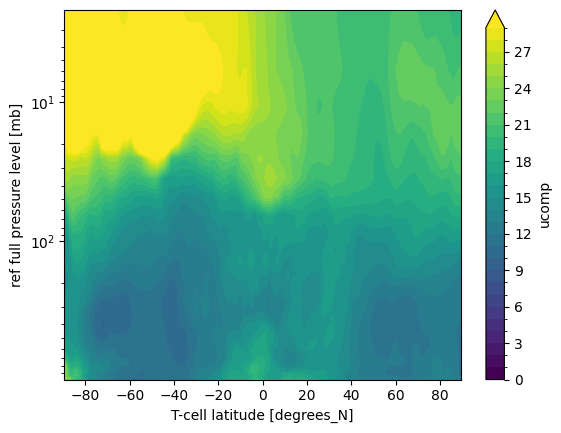

In [9]:
tts_am4_jan.ucomp.mean(dim='lon').plot.contourf(x='lat',y='pfull',yscale='log',yincrease=False,levels=np.arange(30))

In [10]:
tts_icon = icon_params.isel(params=0)
error_dbl_icon = icon_params.isel(params=1)

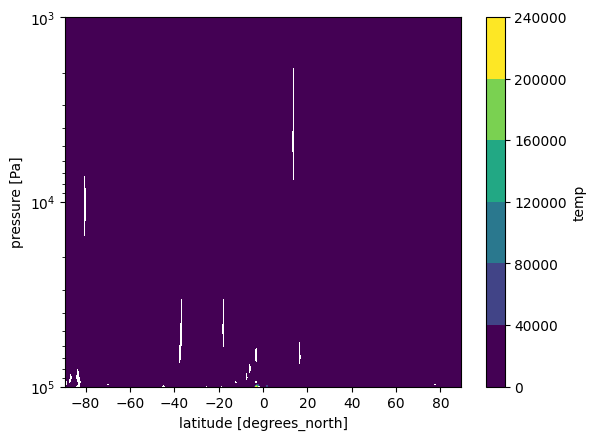

In [12]:
error_dbl_icon.temp.mean(dim='lon').plot.contourf(x='lat',y='plev',yscale='log',yincrease=False)

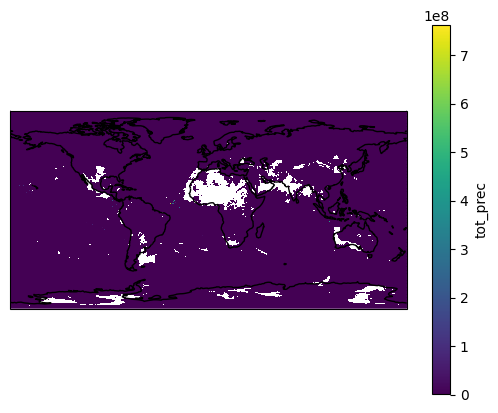

In [21]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
error_dbl_icon.tot_prec.plot.pcolormesh(x='lon',y='lat',transform=ccrs.PlateCarree())
ax.coastlines()